# Semion classifier using CNN.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np

In [3]:
path = "Data/"

In [4]:
digits = []
labels = []
with open(f"{path}Semion_dataset.txt") as f:
    for line in f:
        labels.append(line.split()[-10:].index('1'))
        digits.append([float(x) for x in line.split()[:-10]])

In [5]:
digits = np.array(digits)
labels = np.array(labels)
digits.shape, labels.shape

((1593, 256), (1593,))

In [6]:
labels

array([0, 0, 0, ..., 9, 9, 9])

9

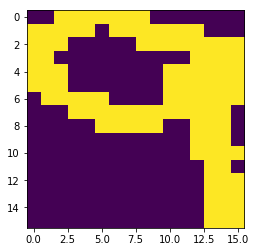

In [7]:
num = 1559
plt.imshow(digits[num].reshape(16, 16))
labels[num]

In [8]:
import pandas as pd

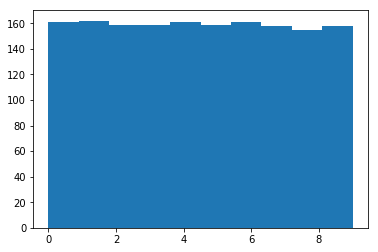

In [9]:
df = pd.DataFrame(labels)
plt.hist(labels);

In [10]:
df[0].value_counts()

1    162
6    161
4    161
0    161
5    159
3    159
2    159
9    158
7    158
8    155
Name: 0, dtype: int64

### CNN with PytourchWrapper fastai

In [11]:
import sys
sys.path.append("../../../fastai/")

In [12]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

D:\Users\Ivan\Documents\Python\Anaconda\envs\fastai\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [13]:
torch.cuda.is_available()

True

In [14]:
torch.backends.cudnn.enabled

True

### Обрабатываем данные перед кормежкой.

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
x_train, x_test, y_train, y_test = train_test_split(digits,
                                                    labels, test_size=0.2,
                                                   random_state=50)

In [18]:
x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                    y_train, test_size=0.2,
                                                   random_state=50)

In [20]:
x_train = x_train.reshape(len(x_train), 16, 16)
x_val = x_val.reshape(len(x_val), 16, 16)
x_test = x_test.reshape(len(x_test), 16, 16)

In [22]:
x_train = np.expand_dims(x_train, axis=1) 
x_val = np.expand_dims(x_val, axis=1) 
x_test = np.expand_dims(x_test, axis=1)

In [23]:
x_train = np.broadcast_to(x_train, (len(x_train), 3, 16, 16)) 
x_val = np.broadcast_to(x_val, (len(x_val), 3, 16, 16)) 
x_test = np.broadcast_to(x_test, (len(x_test), 3, 16, 16))

In [26]:
Data = ImageClassifierData.from_arrays(path, trn = (x_train, y_train),
                                       val = (x_val, y_val), test = x_test,
                                      bs = 12)

In [27]:
x_train.shape, y_train.shape

((1019, 3, 16, 16), (1019,))

Готово. Пора кормить сеточку.

In [28]:
arch=resnet34
learn = ConvLearner.pretrained(arch, Data, precompute=False)

Находим оптимальную скорость обучения.

In [29]:
lrf=learn.lr_find()

 85%|████████████████████████████████████████████████████████████▉           | 72/85 [00:02<00:00, 32.91it/s, loss=4.7]


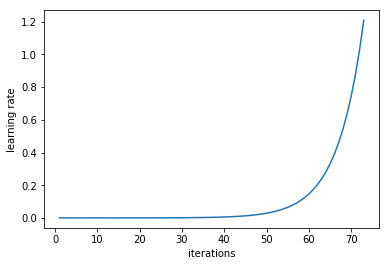

In [30]:
learn.sched.plot_lr()

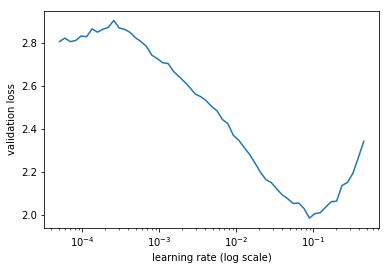

In [31]:
learn.sched.plot()

In [32]:
learn.fit(1e-2, 3)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      1.145245   0.58249    0.803922  
    1      0.840698   0.485263   0.854902                                                                              
    2      0.763106   0.489935   0.85098                                                                               



[array([0.48994]), 0.8509803905206568]

In [33]:
learn.fit(1e-2, 4, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.617554   0.403408   0.886275  
    1      0.576912   0.386031   0.890196                                                                              
    2      0.497721   0.389261   0.87451                                                                               
    3      0.459734   0.363371   0.909804                                                                              



[array([0.36337]), 0.9098039283471949]

In [34]:
learn.unfreeze()

In [35]:
learn

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1), ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d

Добавляем дропаут.

In [36]:
learn.p = 0.2

In [37]:
lr = [1e-4, 1e-3, 1e-2]
learn.fit(lr, 6, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                                                                              
    0      1.988054   1.101088   0.65098   
    1      1.548138   1.095187   0.807843                                                                              
    2      1.137379   0.816151   0.835294                                                                              
    3      1.105398   0.473063   0.866667                                                                              
    4      0.883606   0.396453   0.878431                                                                              
    5      0.778321   0.365893   0.886275                                                                              
    6      0.663186   0.326504   0.894118                                                                              
    7      0.841624   0.336669   0.882353                                                                           

[array([0.11138]), 0.9725490233477424]

In [38]:
preds = learn.predict_array(x_test)

In [39]:
from sklearn.metrics import confusion_matrix
preds = np.argmax(preds, axis=1)
cm = confusion_matrix(y_test, preds)
probs = ['{}'.format(i) for i in range(10)]

[[28  0  0  0  0  0  1  0  1  0]
 [ 0 40  0  0  0  0  0  0  0  0]
 [ 1  1 38  0  0  0  0  1  0  0]
 [ 0  0  0 14  0  2  0  0  0  0]
 [ 0  0  0  0 40  0  0  0  0  0]
 [ 0  0  0  0  0 31  0  0  0  0]
 [ 0  0  0  0  0  0 29  0  3  0]
 [ 0  0  0  0  0  0  0 25  2  0]
 [ 0  0  0  0  1  0  0  0 30  1]
 [ 0  1  0  0  0  0  0  1  1 27]]


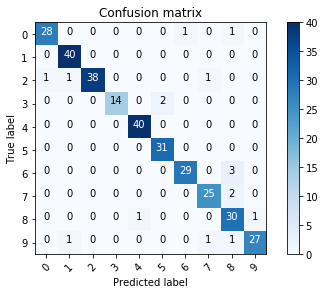

In [40]:
plot_confusion_matrix(cm, probs);

In [44]:
learn.save('all')
learn.load('all')

Мб что то улучшит `Test Time Augmentation`.

In [42]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [43]:
accuracy_np(probs, y)

0.9725490196078431

К сожалению, ничего.

Конечно можно добиться результатов получше, но мне лень..  
По сравнению с KNN здесь результаты лучше.